Test JaxTracer VS Legacy Raytracer

Import Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

#add path
sys.path.insert(0, '../../src/')     # import path/to/synthpy

import simulator.config as config
config.jax_init()

import simulator.beam as beam_initialiser
import simulator.domain as d
import simulator.propagator as p
import processing.diagnostics as diag

import importlib
importlib.reload(beam_initialiser)
importlib.reload(d)
importlib.reload(p)
importlib.reload(diag)

Setting top level path for imports: /home/administrator/Work/UROP_ICL_Internship/synthPy/src

Disabling python multi-threading...
Initialising jax...

Default jax backend: cpu
Available devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


/home/administrator/Programs/anaconda3/envs/testing/lib/python3.12/site-packages/equinox/_config.py:15: UserWarning: The environment variable `EQX_ON_ERROR=breakpoint` is currently set. Note that this should only be used for debugging, as it slows down runtime speed.
  warnings.warn(


<module 'processing.diagnostics' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/src/processing/diagnostics.py'>

Create a domain

In [2]:
## Sinusoidal test
N_V       =     100
M_V       =     2 * N_V + 1
ne_extent =     5.0e-3  # 5 mm extent of the electron density cube

M_V = 128

# this function doubles the length
ne_x      =     np.linspace(-ne_extent, ne_extent, M_V)
ne_y      =     np.linspace(-ne_extent, ne_extent, M_V)
ne_z      =     np.linspace(-ne_extent, ne_extent, M_V)

# therefore to stay consistent with legacy code, we create extent's and THEN double them
# rather than just setting them to the desired length in the first place
lengths = 2 * np.array([ne_extent, ne_extent, ne_extent])

probing_direction = "z"

ne_0      =     2e17 * 1e6 #2e17 cm^-3 amplitude density
Ly        =     1e-3 # 1 mm perturbation wavelength
s         =     -4e-3 #4 mm exponential growth rate

cos = d.ScalarDomain(lengths, M_V, ne_type = "test_exponential_cos", probing_direction = probing_direction, ne_0 = ne_0, Ly = Ly, s = s)
#cos       =     pt.ElectronCube(ne_x, ne_y, ne_z, ne_extent)

#cos        =     cos.test_exponential_cos(ne_0 = ne_0, Ly = Ly, s = s)

#cos.calc_dndr()
# cos.clear_memory()

Predicted size in memory of domain: 8.0 MB

Memory prior to domain creation:
 - total : 14.982200622558594 GB
 - free  : 5.526084899902344 GB
 - used  : 8.987770080566406 GB
67108864
64.0 MB
64.0 MB
Est. memory limit: 64.0 MB --> inc. +100% variance margin.

Coordinates have shape of (128, 128, 128) --> no padding required.

Generating test exponential decay periodic -e field...


Visualise the electon density cube - this need to be for all line of sight
3 subplots with the xy-plane, yz-plane, zx-plane

In [3]:
from processing.plotting import graph_domain

Tracing using JaxTracer

In [4]:
lwl = 1064e-9 #define laser wavelength

# initialise beam
Np = 100000    # number of photons
divergence = 5e-5
beam_size = ne_extent * 0.9
beam_type = "square"

beam_definition = beam_initialiser.Beam(
    Np, beam_size, # square beam width/height
    divergence, # realistic divergence value
    ne_extent, # where to initialise rays (converts to -ne_extent)
    probing_direction = probing_direction,
    wavelength = lwl,
    beam_type = beam_type
)

rf, _, duration = p.solve(beam_definition.s0, cos, ne_extent)


Size in memory of initial rays: 67.901611328125 MB
 --> Np = 100000

No need to generate any sections of the domain, batching not utilised.
 --> tracing a depth of 0.005 mm's to the target depth of 0.005 mm's

Running device: cpu, with: 16 cores.
NamedSharding(mesh=Mesh('rows': 16, axis_types=(Auto,)), spec=PartitionSpec('rows', None), memory_kind=unpinned_host)

jax compilation of solver took: 0.0007355213165283203 seconds

/home/administrator/Programs/anaconda3/envs/testing/lib/python3.12/site-packages/equinox/_errors.py:171: UserWarning: Ignoring intermediate `jax.jit` decorator, to work around JAX issue #16732, as `EQX_ON_ERROR=breakpoint` is set.
  warnings.warn(



Completed ray trace in 6.1920004 seconds.

Parallelised output has resulting 3D matrix of form: [batch_count, (save_points_per_region - 1) * ScalarDomain.region_count, 9]: (100000, 2, 9)
 - 2 to account for the start and end results (typical, can be greater if set)
 - 9 containing the 3 position and velocity components, amplitude, phase and polarisation
 - If batch_count is lower than expected, this is likely due to jax's forced integer batch sharding requirement over cpu cores.

We slice the end result and transpose into the form: (4, 100000) to work with later code.


In [5]:
from processing.plotting import general_ray_plots

l_x = 0
u_x = 0.3
l_y = -5
u_y = 5

Results and time

Completed updated ray trace in 6.192464113235474 seconds for 100000 rays in a 128^3 domain.
(4, 100000)
(4, 99602)

All rays incident on lens!

rf size expected: [99602. 99602.]
rf after clearing nan's: [99602. 99602.]

All rays incident on lens!

rf size expected: [99602. 99602.]
rf after clearing nan's: [99602. 99602.]


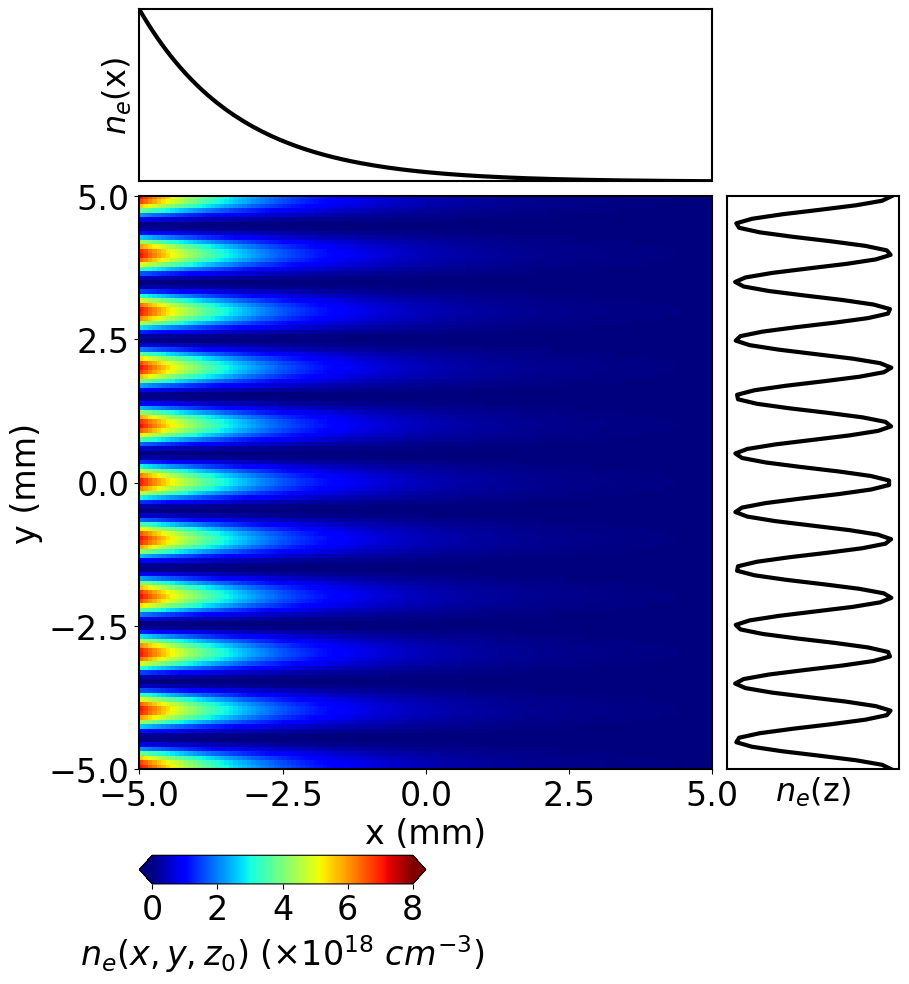

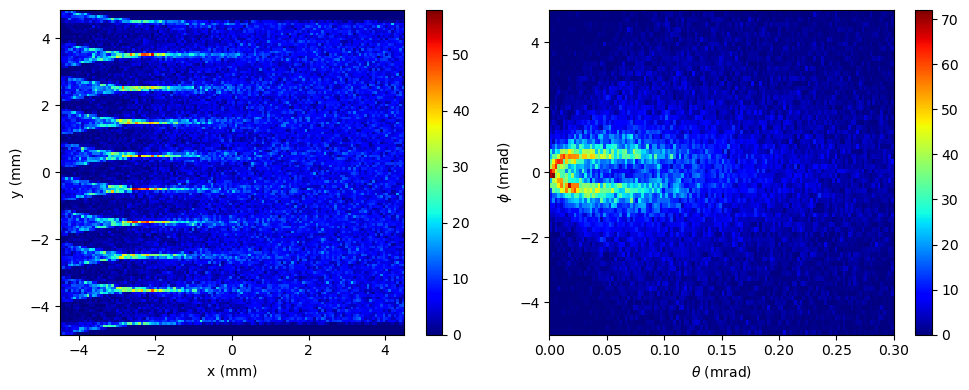

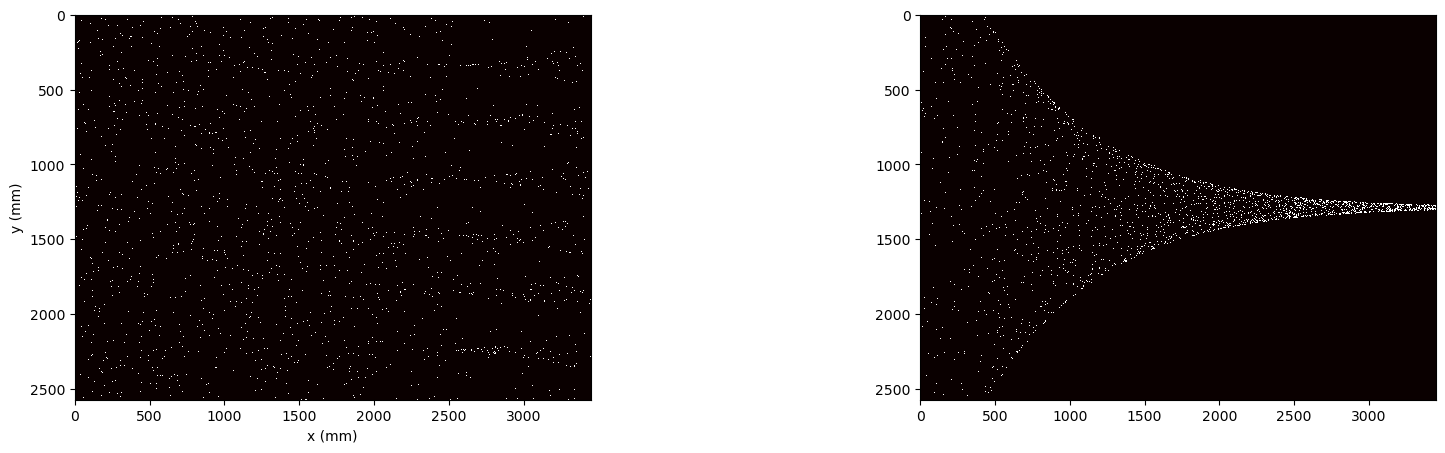

In [6]:
### Add here plots of the output rays in subplots (shadow and refractogram)

graph_domain(cos)

print("Completed updated ray trace in {} seconds for {} rays in a {}^3 domain.".format(duration, Np, M_V))

general_ray_plots(rf, M_V, lwl, l_x = l_x, u_x = u_x, l_y = l_y, u_y = u_y)

Tracing using Legacy Raytracer 

In [7]:
### Add the code here

import legacy.full_solver as fs
import legacy.rtm_solver as rtm

importlib.reload(fs)
importlib.reload(rtm)

slab = fs.ScalarDomain(ne_x, ne_y, ne_z, ne_extent)
slab.test_exponential_cos(n_e0 = 2e17 * 1e6, Ly = 1e-3, s = -4e-3)
slab.calc_dndr(lwl)

## Initialise rays and solve
s0 = fs.init_beam(
    Np, beam_size, divergence, ne_extent,
    probing_direction = probing_direction,
    beam_type = beam_type
)

slab.solve(s0)
rf = slab.rf

Starting ray trace.
Ray trace completed in:	 5.076260089874268 s


Results and time

Completed updated ray trace in 5.076260089874268 seconds for 100000 rays in a 128^3 domain.
(4, 100000)
(4, 99895)

All rays incident on lens!

rf size expected: [99895. 99895.]
rf after clearing nan's: [99895. 99895.]

All rays incident on lens!

rf size expected: [99895. 99895.]
rf after clearing nan's: [99895. 99895.]


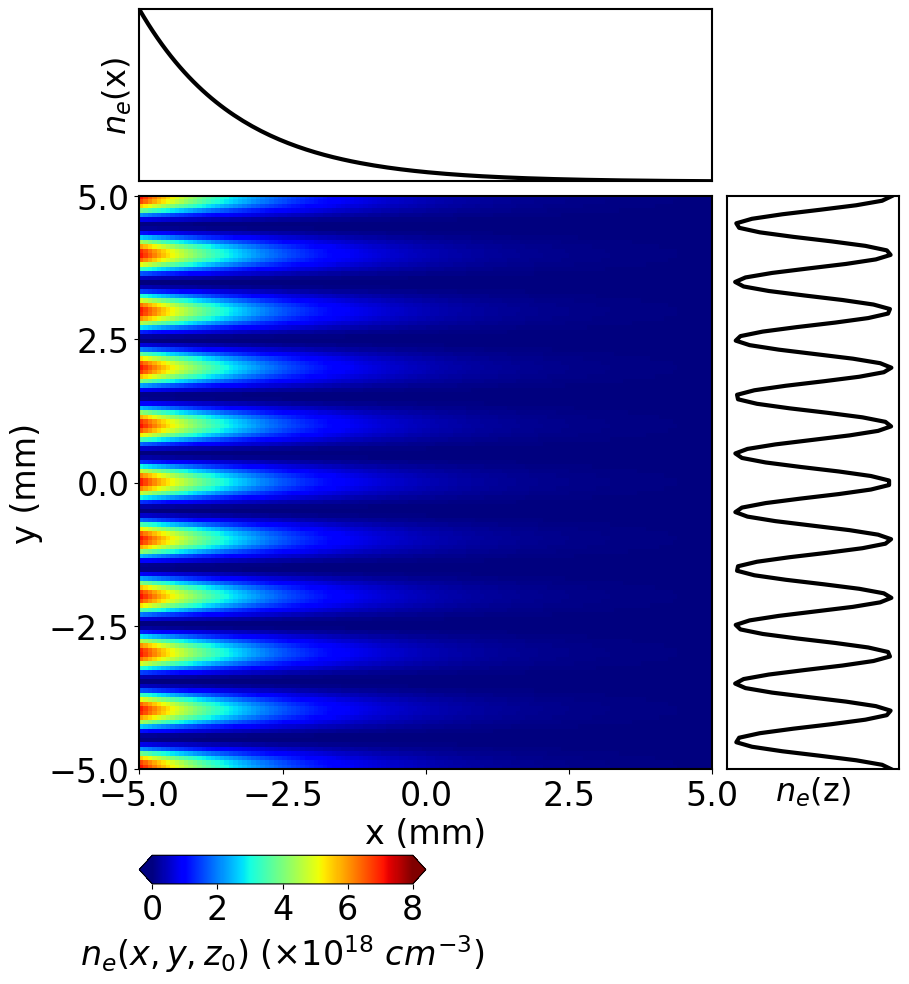

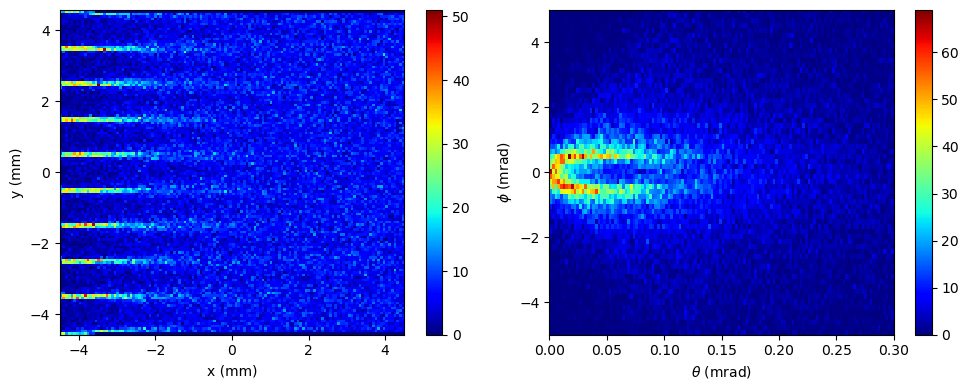

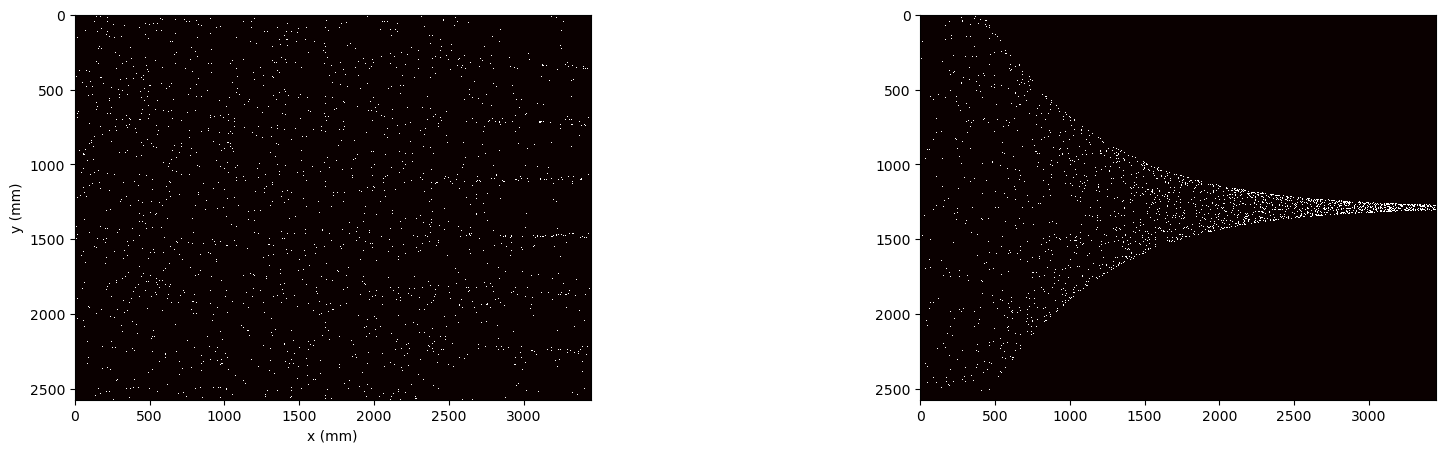

In [10]:
### Add here plots of the output rays in subplots (shadow and refractogram)

graph_domain(slab)

print("Completed updated ray trace in {} seconds for {} rays in a {}^3 domain.".format(slab.duration, Np, M_V))

## Plot
general_ray_plots(rf, M_V, lwl, l_x = l_x, u_x = u_x, l_y = l_y, u_y = u_y)